# 🏃 Analyse de données Strava - Speed

Ce notebook analyse la série temporelle **speed** issue d'un fichier d'activité Strava/Garmin.

**Objectifs:**
- Charger et nettoyer les données
- Visualiser la série temporelle
- Effectuer une décomposition STL (Seasonal-Trend-Loess)
- Analyser la stationnarité

# Import

In [10]:
# ======================================
# 📦 1. Import des bibliothèques
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


# Semi 1

In [11]:
# ======================================
# 📂 2. Chargement du dataset
# ======================================
filepath = r'C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\GOTOES_FIT-CSV_8407101122069242.csv'

# Charger le CSV (délimiteur virgule standard)
df = pd.read_csv(filepath)

print(f"✅ Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")
print(f"\nColonnes disponibles: {df.columns.tolist()}")

# Vérifier si right_power_phase_peak a des données
if 'right_power_phase_peak' in df.columns:
    non_null = df['right_power_phase_peak'].notna().sum()
    print(f"\n✅ Colonne 'right_power_phase_peak': {non_null} valeurs non-nulles ({non_null/len(df)*100:.1f}%)")
    print(f"   Premières valeurs: {df['right_power_phase_peak'].head().tolist()}")

# Afficher les premières lignes
df.head()

✅ Dataset chargé: 5860 lignes, 123 colonnes

Colonnes disponibles: ['GOTOES_CSV', 'timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance', 'grade', 'resistance', 'time_from_course', 'cycle_length', 'temperature', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'speed_1s', 'cycles', 'total_cycles', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'compressed_accumulated_power', 'accumulated_power', 'left_right_balance', 'gps_accuracy', 'vertical_speed', 'calories', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'vertical_oscillation', 'stance_time_percent', 'stance_time', 'activity_type', 'left_torque_effectiveness', 'right_torque_effectiveness', 'left_pedal_smoothness', 'right_pedal_smoothness', 'combined_pedal_smoothness', 'time128', 'stroke_type', 'zone', 'ball_speed', 'cadence256', 'fractional_cadence', '

,GOTOES_CSV,timestamp,position_lat,position_long,altitude,heart_rate,cadence,distance,speed,power,...,Unnamed: 113,Unnamed: 114,Unnamed: 115,grit,flow,Unnamed: 118,ebike_travel_range,ebike_battery_level,ebike_assist_mode,ebike_assist_level_percent
NaN,2025-10-15T07:32:16,48.8946625,2.275154,NaN,69.0,0.0,0.67,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,2025-10-15T07:32:17,48.8946694,2.275152,NaN,68.0,0.0,1.80,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,2025-10-15T07:32:18,48.8946801,2.275136,NaN,68.0,0.0,3.07,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,2025-10-15T07:32:19,48.8947003,2.275113,NaN,68.0,0.0,6.30,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,2025-10-15T07:32:20,48.8947165,2.275097,NaN,69.0,0.0,8.03,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# ======================================
# 🔍 3. Vérification de right_power_phase_peak
# ======================================
target_col = 'right_power_phase_peak'

if target_col not in df.columns:
    raise ValueError(f"La colonne '{target_col}' n'existe pas! Colonnes: {df.columns.tolist()}")

print(f"✅ Colonne '{target_col}' trouvée")
print(f"\nStatistiques avant nettoyage:")
print(f"  - Total de lignes: {len(df)}")
print(f"  - Valeurs non-nulles: {df[target_col].notna().sum()}")
print(f"  - Valeurs nulles: {df[target_col].isna().sum()}")

# Afficher les premières valeurs
print(f"\nPremières valeurs de {target_col}:")
print(df[target_col].head(10))

✅ Colonne 'right_power_phase_peak' trouvée

Statistiques avant nettoyage:
  - Total de lignes: 5860
  - Valeurs non-nulles: 5858
  - Valeurs nulles: 2

Premières valeurs de right_power_phase_peak:
NaN     0.000
NaN     0.000
NaN     0.000
NaN     0.000
NaN     4.198
NaN     6.919
NaN    10.379
NaN    13.838
NaN    14.076
NaN    14.713
Name: right_power_phase_peak, dtype: float64


In [13]:
# ======================================
# 🧹 4. Nettoyage des données
# ======================================

print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(df)} lignes")

# Convertir en numérique
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
print(f"  Après conversion numérique: {df[target_col].notna().sum()} valeurs non-nulles")

# Vérifier la présence de GOTOES_CSV
if 'GOTOES_CSV' in df.columns:
    print(f"  Colonne 'GOTOES_CSV' présente: {df['GOTOES_CSV'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur GOTOES_CSV: {df['GOTOES_CSV'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'GOTOES_CSV' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(df)}")
print(f"  - Lignes après: {len(df)}")
print(f"  - Lignes supprimées: {len(df) - len(df)}")

# Créer une série temporelle avec index
if 'GOTOES_CSV' in df.columns:
    print(f"\n🔍 Création de l'index temporel avec 'GOTOES_CSV'...")
    
    # Sélectionner les colonnes
    ts_data = df[['GOTOES_CSV', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    
    # Dropna sur les deux colonnes
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    
    # Convertir en datetime
    ts_data['GOTOES_CSV'] = pd.to_datetime(ts_data['GOTOES_CSV'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['GOTOES_CSV'].notna().sum()} timestamps valides")
    
    # Dropna final
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    # Mettre en index
    ts_data = ts_data.set_index('GOTOES_CSV')
    print(f"\n✅ Index temporel basé sur 'GOTOES_CSV'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in df.columns:
    ts_data = df[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = df[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

🔍 DIAGNOSTIC DU NETTOYAGE:
  Données de départ: 5860 lignes
  Après conversion numérique: 5858 valeurs non-nulles
  Colonne 'GOTOES_CSV' présente: 5860 valeurs non-nulles
  Exemple de valeur GOTOES_CSV: 2025-10-15T07:32:16

✅ Nettoyage effectué:
  - Lignes avant: 5860
  - Lignes après: 5860
  - Lignes supprimées: 0

🔍 Création de l'index temporel avec 'GOTOES_CSV'...
  Après sélection colonnes: 5860 lignes
  Après dropna initial: 5858 lignes
  Après conversion datetime: 5858 timestamps valides
  Après dropna final: 5858 lignes

✅ Index temporel basé sur 'GOTOES_CSV'

⏱️ Plage temporelle de la série :
  Début : 2025-10-15 07:32:16
  Fin   : 2025-10-15 09:41:10
  Durée totale : 0 days 02:08:54

RÉSULTAT FINAL: 5858 points valides

Premières valeurs de la série:
                     right_power_phase_peak
GOTOES_CSV                                 
2025-10-15 07:32:16                   0.000
2025-10-15 07:32:17                   0.000
2025-10-15 07:32:18                   0.000
2025-10-15

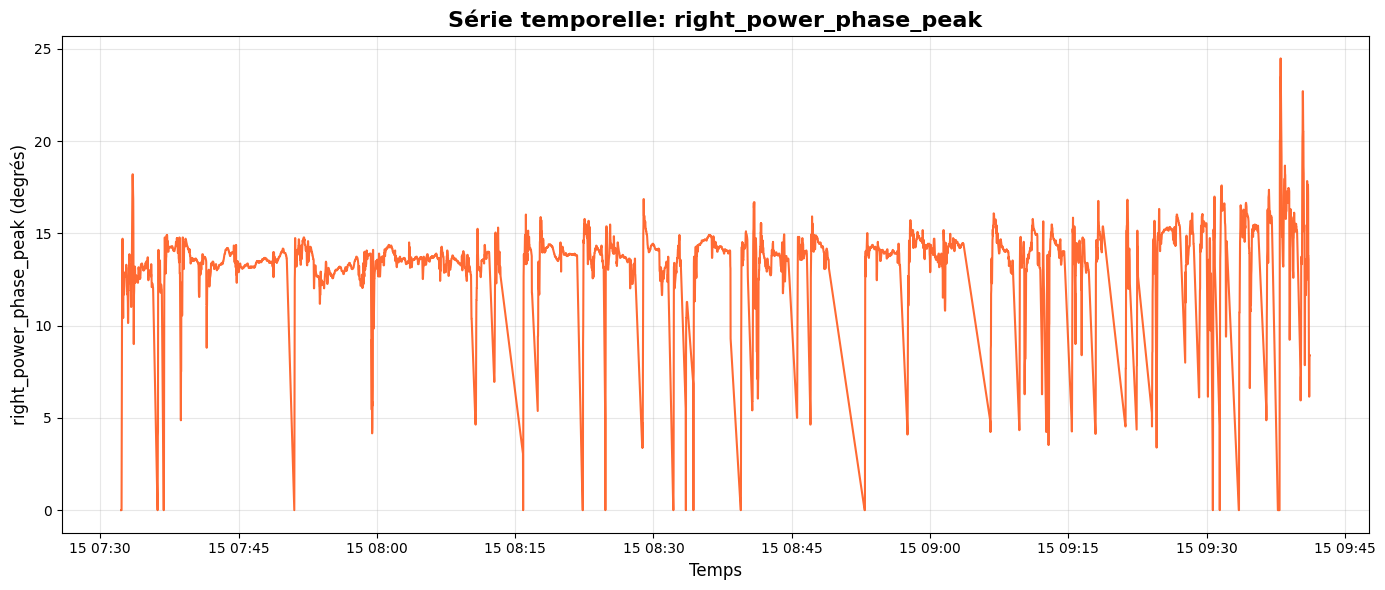

📈 Graphique de la série temporelle affiché


In [14]:
# ======================================
# 📊 5. Visualisation de la série temporelle
# ======================================

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

STATISTIQUES DESCRIPTIVES
Moyenne        : 13.5959°
Médiane        : 13.8380°
Écart-type     : 2.0163°
Min            : 0.0000°
Max            : 24.4870°
Q1 (25%)       : 13.2700°
Q3 (75%)       : 14.3420°


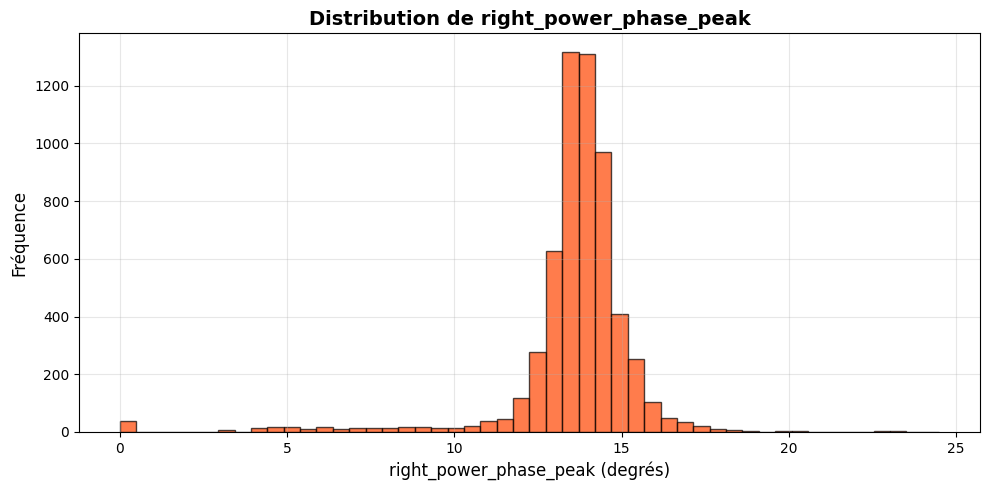

In [15]:
# ======================================
# 📊 6. Statistiques de base
# ======================================

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")

# Histogramme
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🔄 Décomposition STL en cours...


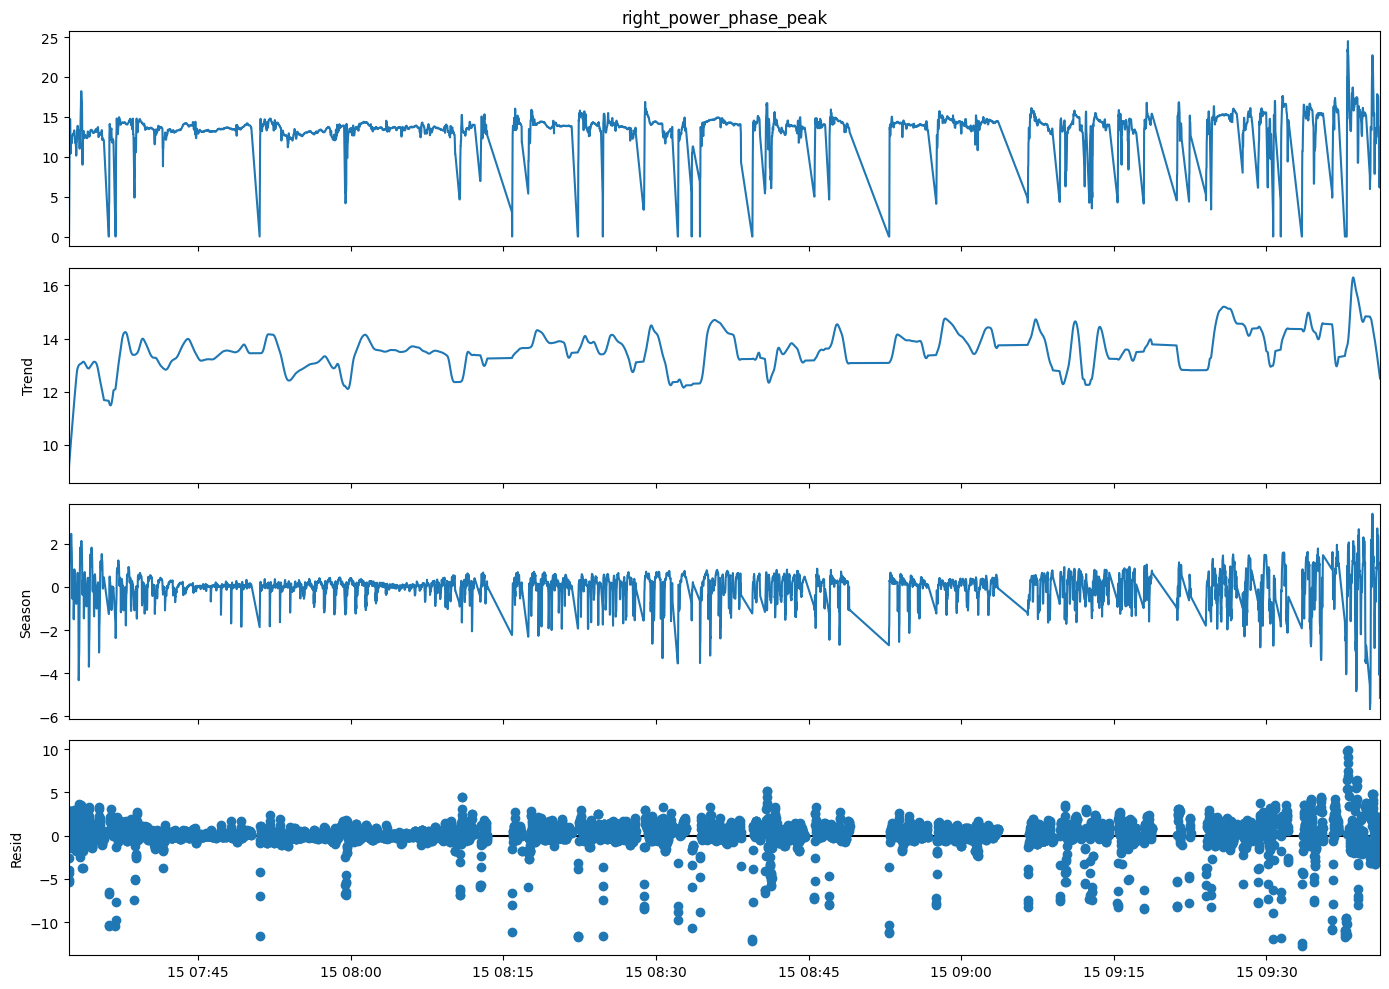

✅ Décomposition STL effectuée (période=60)


In [16]:
# ======================================
# 🔄 7. Décomposition STL (Seasonal-Trend-Loess)
# ======================================

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    # Choisir une période appropriée (par exemple 60 pour une minute si données par seconde)
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    # Visualiser la décomposition
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

In [17]:
# ======================================
# 📈 8. Test de stationnarité (Augmented Dickey-Fuller)
# ======================================

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

# Interprétation
if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -17.827067
P-value: 0.000000

Valeurs critiques:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)


📊 Calcul et affichage des fonctions d’autocorrélation...


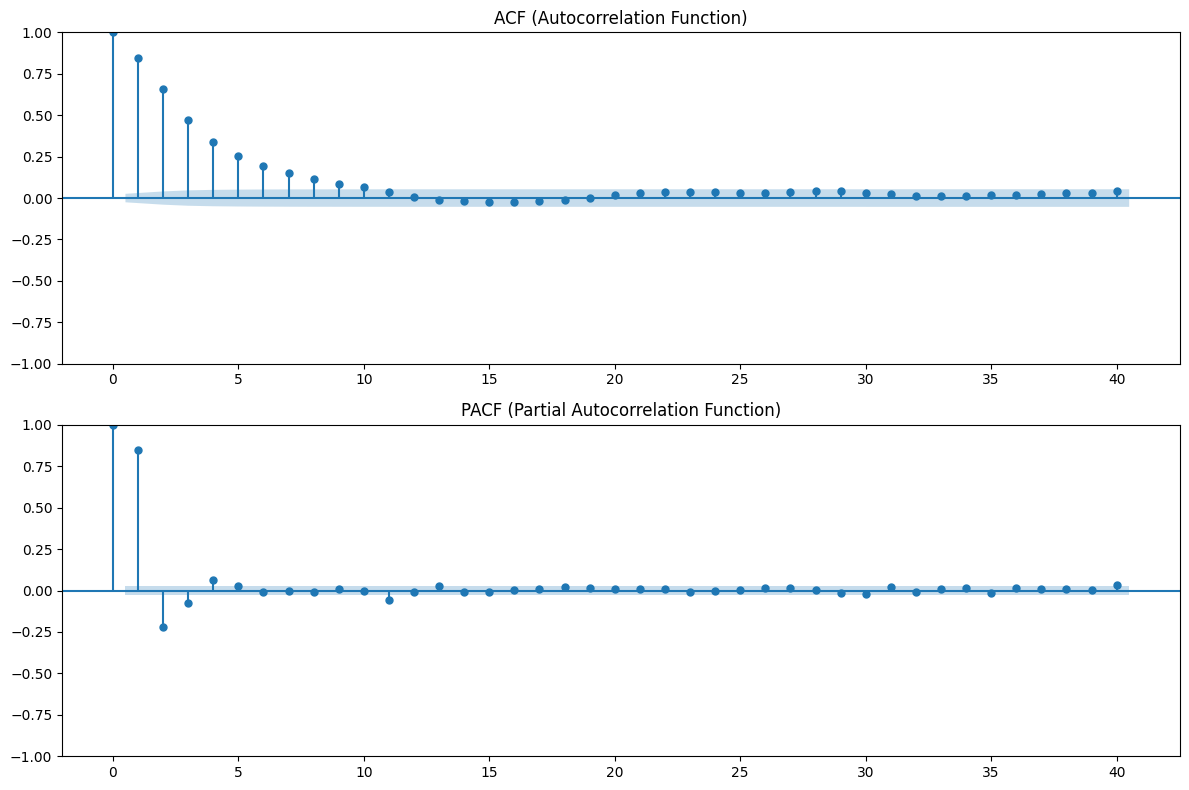

In [18]:
# ======================================
# 📈 9. Analyse avancée : ACF, PACF, autocorrélation
# ======================================

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

if len(ts_data) > 30:
    print("📊 Calcul et affichage des fonctions d’autocorrélation...")
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(ts_data[target_col].dropna(), ax=ax[0], lags=40)
    ax[0].set_title("ACF (Autocorrelation Function)")
    
    plot_pacf(ts_data[target_col].dropna(), ax=ax[1], lags=40, method='ywm')
    ax[1].set_title("PACF (Partial Autocorrelation Function)")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Série trop courte pour ACF/PACF fiables.")


🔍 Détection des points de rupture dans la série...


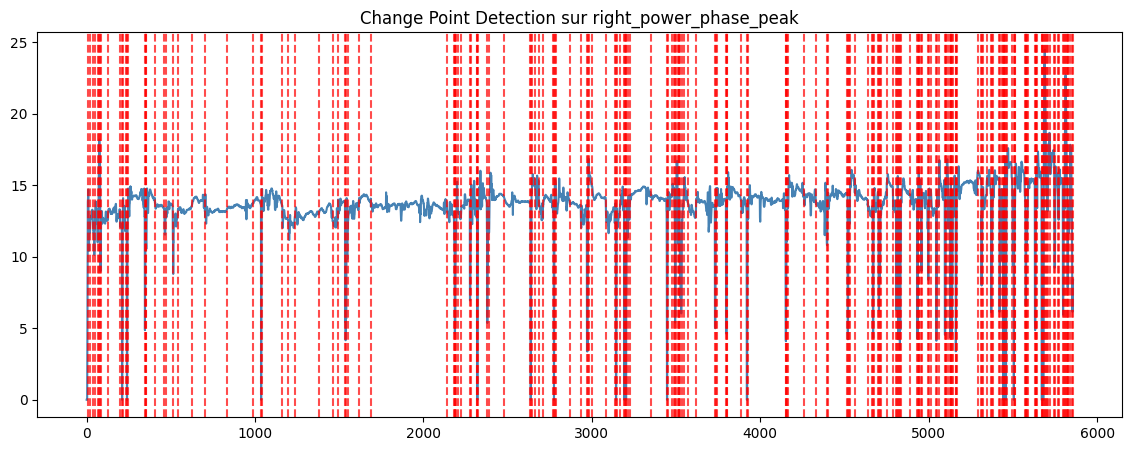

✅ 212 ruptures détectées aux indices : [5, 20, 40, 50, 70, 75, 80, 85, 125, 200, 210, 215, 235, 240, 245, 345, 350, 355, 405, 460, 470, 510, 540, 625, 700, 835, 985, 1035, 1040, 1160, 1195, 1235, 1380, 1460, 1490, 1535, 1540, 1550, 1615, 1690, 2140, 2180, 2185, 2190, 2195, 2205, 2225, 2275, 2280, 2315, 2320, 2325, 2375, 2390, 2480, 2635, 2640, 2645, 2665, 2685, 2710, 2770, 2775, 2780, 2785, 2870, 2935, 2970, 2975, 2980, 3000, 3085, 3140, 3145, 3150, 3165, 3190, 3195, 3200, 3205, 3215, 3225, 3350, 3445, 3450, 3475, 3490, 3495, 3500, 3510, 3515, 3520, 3525, 3535, 3545, 3570, 3620, 3730, 3735, 3740, 3795, 3800, 3805, 3885, 3920, 3925, 4150, 4155, 4160, 4165, 4260, 4330, 4395, 4400, 4515, 4520, 4525, 4535, 4560, 4640, 4665, 4670, 4675, 4700, 4705, 4710, 4715, 4750, 4790, 4805, 4810, 4820, 4825, 4830, 4835, 4890, 4930, 4935, 4940, 4945, 4955, 4960, 4995, 5000, 5015, 5045, 5050, 5060, 5095, 5100, 5105, 5115, 5125, 5130, 5135, 5140, 5145, 5160, 5165, 5170, 5290, 5310, 5315, 5320, 5345, 5370, 

In [20]:
# ======================================
# 🔍 10. Détection de ruptures (Change Point Detection)
# ======================================

from ruptures import Binseg, Pelt, KernelCPD
import ruptures as rpt

print("🔍 Détection des points de rupture dans la série...")

signal = ts_data[target_col].dropna().values

# On peut utiliser Pelt (rapide et précis)
model = "l2"  # distance L2 (euclidienne)
algo = rpt.Pelt(model=model).fit(signal)

# On fixe un seuil de pénalité (ajuste la sensibilité)
result = algo.predict(pen=5)

# Visualisation des ruptures
plt.figure(figsize=(14, 5))
plt.plot(signal, color='steelblue')
for cp in result:
    plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
plt.title(f"Change Point Detection sur {target_col}")
plt.show()

print(f"✅ {len(result)-1} ruptures détectées aux indices : {result[:-1]}")


🌊 Analyse fréquentielle (Transformée de Fourier)


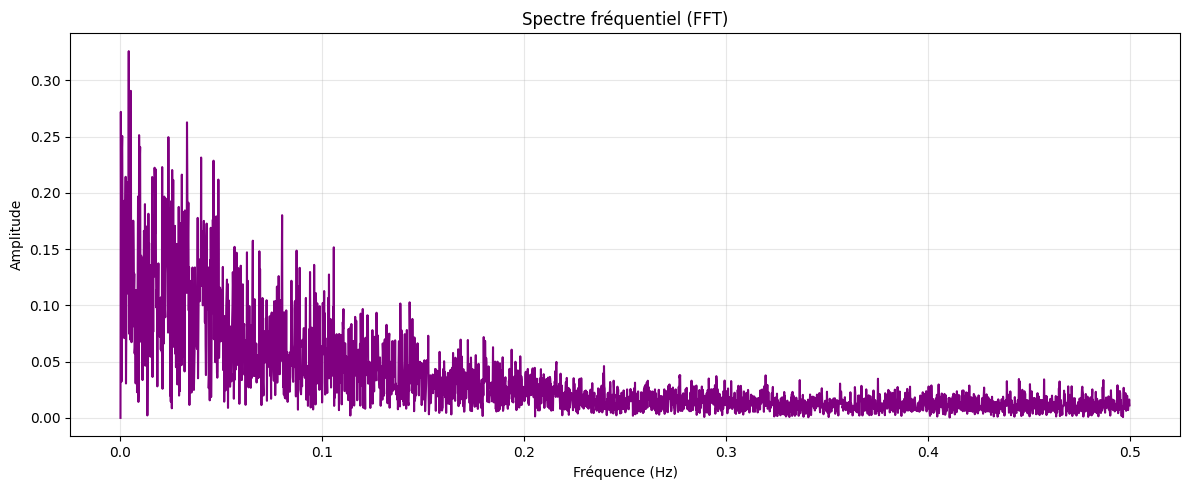

In [21]:
# ======================================
# 🌊 11. Transformée de Fourier Discrète (DFT)
# ======================================

from scipy.fft import fft, fftfreq

print("🌊 Analyse fréquentielle (Transformée de Fourier)")

y = ts_data[target_col].dropna().values
n = len(y)
timestep = 1  # suppose 1 Hz (1 échantillon/seconde) → ajuste selon ta fréquence réelle

# Calcul de la transformée
yf = fft(y - np.mean(y))  # centrée
xf = fftfreq(n, timestep)[:n//2]  # fréquences positives

# Spectre de puissance
plt.figure(figsize=(12, 5))
plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), color='purple')
plt.title("Spectre fréquentiel (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...
AIC : 17073.4310
BIC : 17100.1332
L1-norm (somme des valeurs absolues) : 2057.2246
L2-norm (norme quadratique) : 80.3193


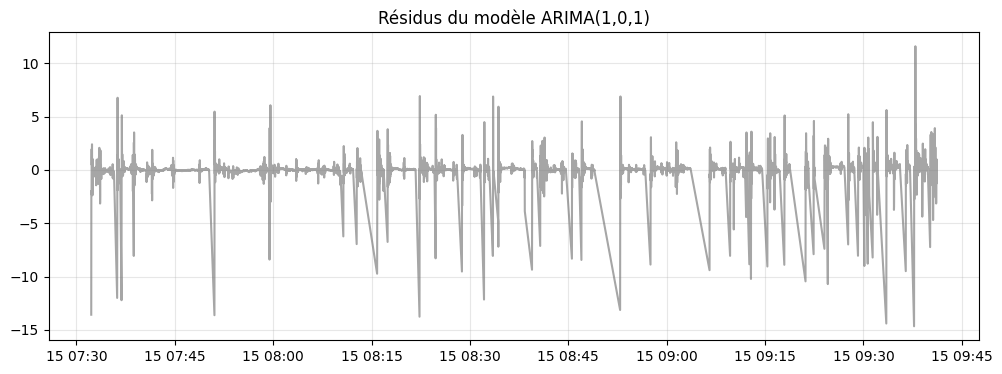

In [22]:
# ======================================
# 📉 12. Calcul des critères AIC / BIC avec modèles ARIMA
# ======================================

from statsmodels.tsa.arima.model import ARIMA

print("📉 Calcul des critères d’information (AIC / BIC) via modèle ARIMA...")

# On tente un modèle simple ARIMA(1,0,1)
try:
    model = ARIMA(ts_data[target_col].dropna(), order=(1, 0, 1))
    result = model.fit()
    
    print(f"AIC : {result.aic:.4f}")
    print(f"BIC : {result.bic:.4f}")
    print(f"L1-norm (somme des valeurs absolues) : {np.sum(np.abs(result.resid)):.4f}")
    print(f"L2-norm (norme quadratique) : {np.sqrt(np.sum(result.resid**2)):.4f}")
    
    plt.figure(figsize=(12, 4))
    plt.plot(result.resid, color='gray', alpha=0.7)
    plt.title("Résidus du modèle ARIMA(1,0,1)")
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"❌ Erreur lors de l’ajustement du modèle ARIMA : {e}")


🔁 Autocorrélation globale sur la série...


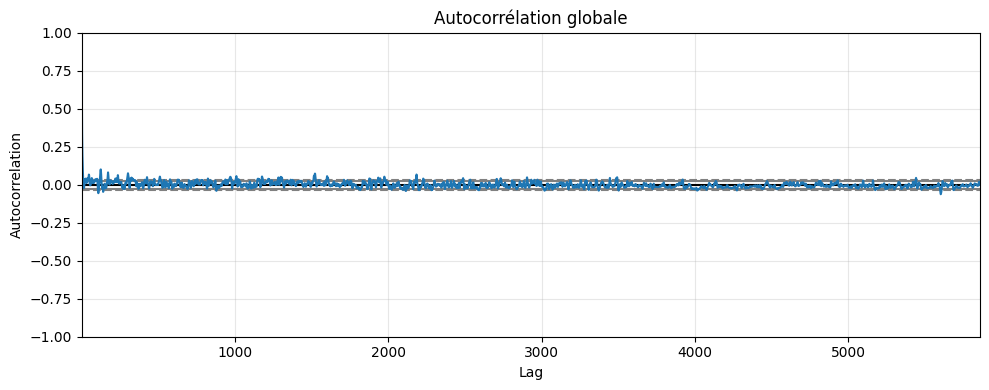

In [23]:
# ======================================
# 🔁 13. Corrélation croisée (autocorrélation sur décalages)
# ======================================

from pandas.plotting import autocorrelation_plot

print("🔁 Autocorrélation globale sur la série...")

plt.figure(figsize=(10, 4))
autocorrelation_plot(ts_data[target_col])
plt.title("Autocorrélation globale")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
from scipy.spatial.distance import euclidean

# Exemple : découper la série en deux segments de taille égale
y = ts_data[target_col].dropna().values
n = len(y) // 2
segment1, segment2 = y[:n], y[n:2*n]

# Calcul de distance Euclidienne
dist_euclid = euclidean(segment1[:min(len(segment1), len(segment2))],
                        segment2[:min(len(segment1), len(segment2))])

print(f"📏 Distance euclidienne entre les deux segments : {dist_euclid:.4f}")


📏 Distance euclidienne entre les deux segments : 153.2406


In [25]:
from fastdtw import fastdtw

# Calcul de la distance DTW
distance_dtw, path = fastdtw(segment1, segment2, dist=euclidean)
print(f"🔄 Distance DTW entre les deux segments : {distance_dtw:.4f}")


ValueError: Input vector should be 1-D.

🔍 Calcul du Matrix Profile pour la détection de motifs...
🏁 Motif principal trouvé à l’indice 2539


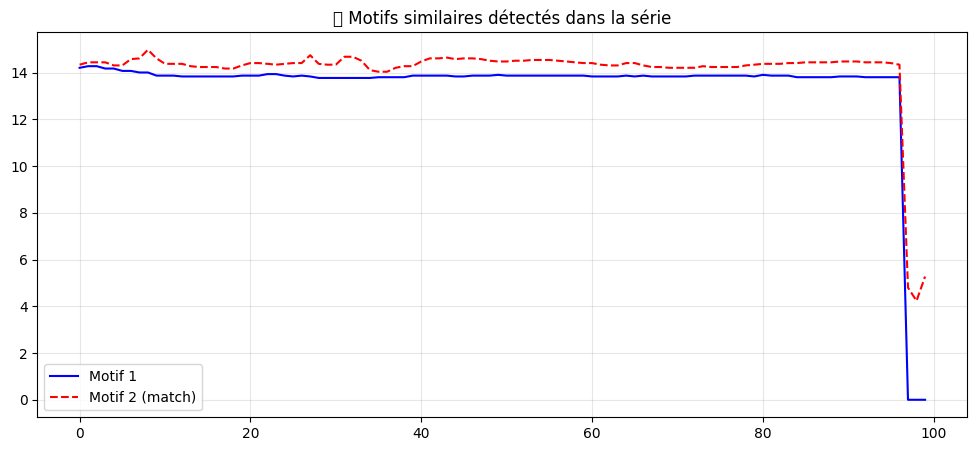

In [26]:
import stumpy

print("🔍 Calcul du Matrix Profile pour la détection de motifs...")

# Convertir la série en numpy
series = ts_data[target_col].dropna().values.astype(float)

# Taille de la fenêtre (ex : 100 points = environ quelques secondes)
m = 100  

# Calcul du Matrix Profile
mp = stumpy.stump(series, m=m)

# mp[:, 0] contient les valeurs du profil (distance minimale pour chaque sous-séquence)
# Trouvons le motif le plus récurrent (plus petite distance)
motif_idx = np.argmin(mp[:, 0])
print(f"🏁 Motif principal trouvé à l’indice {motif_idx}")

# On récupère le motif et son match le plus proche
motif1 = series[motif_idx:motif_idx+m]
motif2 = series[int(mp[motif_idx, 1]):int(mp[motif_idx, 1])+m]

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(motif1, label='Motif 1', color='blue')
plt.plot(motif2, label='Motif 2 (match)', color='red', linestyle='--')
plt.title("🔍 Motifs similaires détectés dans la série")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


⚠️ Discord (anomalie potentielle) détectée à l’indice 1705


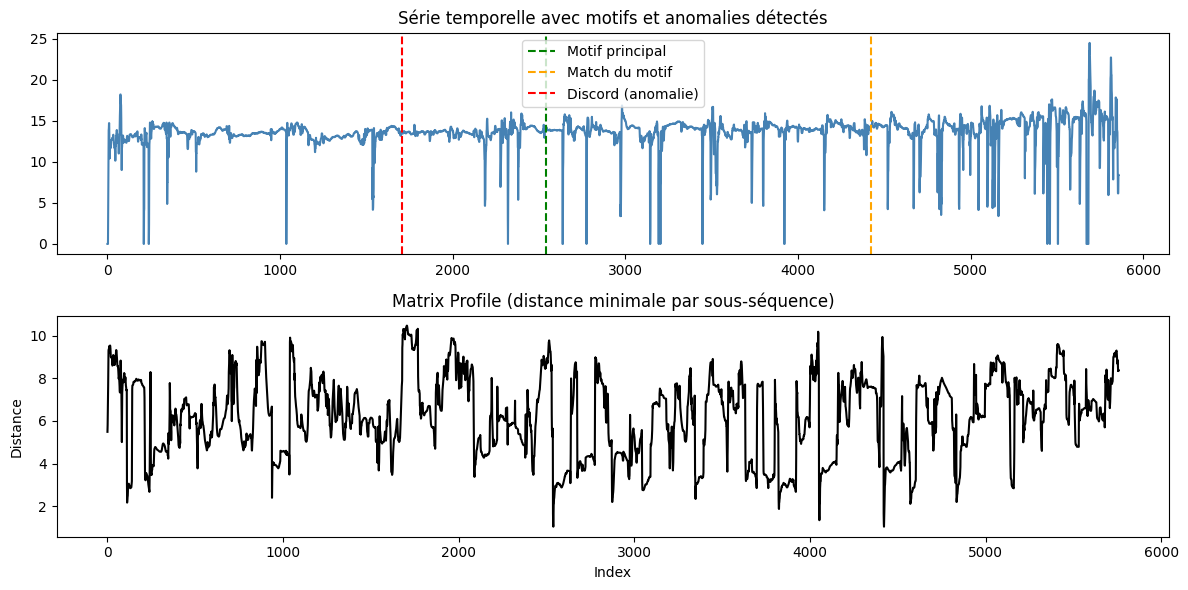

In [27]:
# Discord = sous-séquence la plus éloignée de toutes les autres
discord_idx = np.argmax(mp[:, 0])
print(f"⚠️ Discord (anomalie potentielle) détectée à l’indice {discord_idx}")

# Visualisation
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(series, color='steelblue')
plt.axvline(motif_idx, color='green', linestyle='--', label='Motif principal')
plt.axvline(int(mp[motif_idx,1]), color='orange', linestyle='--', label='Match du motif')
plt.axvline(discord_idx, color='red', linestyle='--', label='Discord (anomalie)')
plt.title("Série temporelle avec motifs et anomalies détectés")
plt.legend()

plt.subplot(2,1,2)
plt.plot(mp[:,0], color='black')
plt.title("Matrix Profile (distance minimale par sous-séquence)")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


# Marathon 1

✅ Dataset chargé: 12222 lignes, 123 colonnes

Colonnes disponibles: ['GOTOES_CSV', 'timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance', 'grade', 'resistance', 'time_from_course', 'cycle_length', 'temperature', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'speed_1s', 'cycles', 'total_cycles', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'compressed_accumulated_power', 'accumulated_power', 'left_right_balance', 'gps_accuracy', 'vertical_speed', 'calories', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'vertical_oscillation', 'stance_time_percent', 'stance_time', 'activity_type', 'left_torque_effectiveness', 'right_torque_effectiveness', 'left_pedal_smoothness', 'right_pedal_smoothness', 'combined_pedal_smoothness', 'time128', 'stroke_type', 'zone', 'ball_speed', 'cadence256', 'fractional_cadence', 

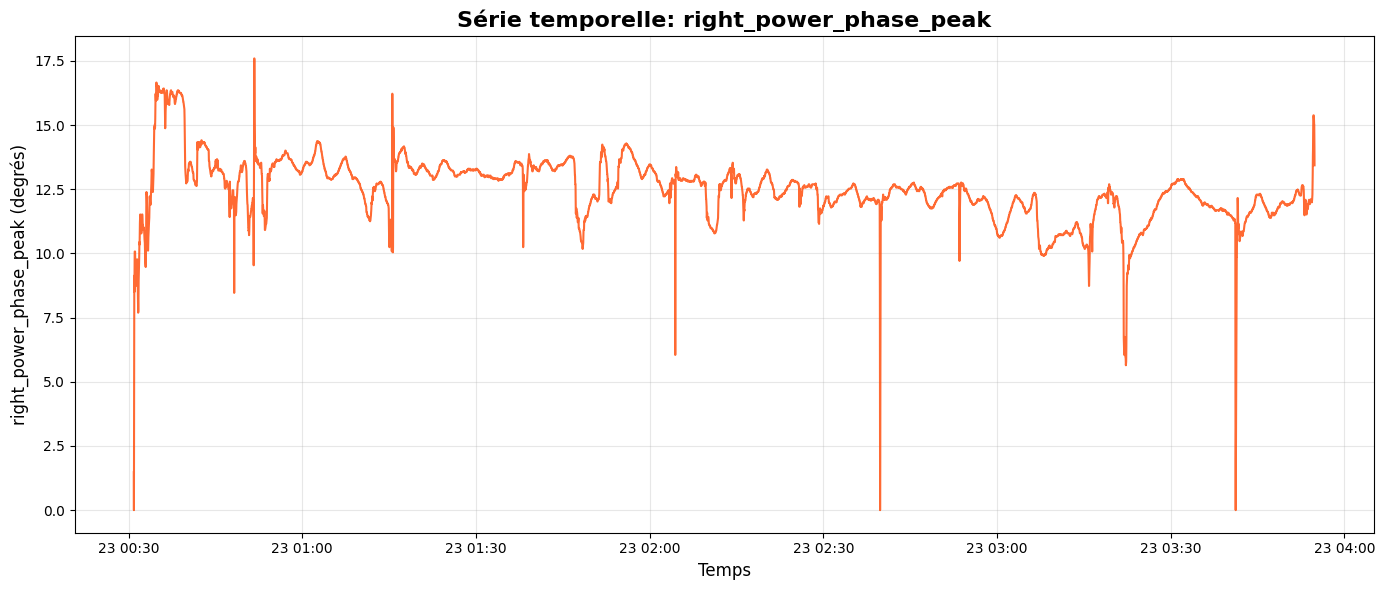

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 12.4961°
Médiane        : 12.5280°
Écart-type     : 1.2155°
Min            : 0.0000°
Max            : 17.6000°
Q1 (25%)       : 11.9230°
Q3 (75%)       : 13.2010°


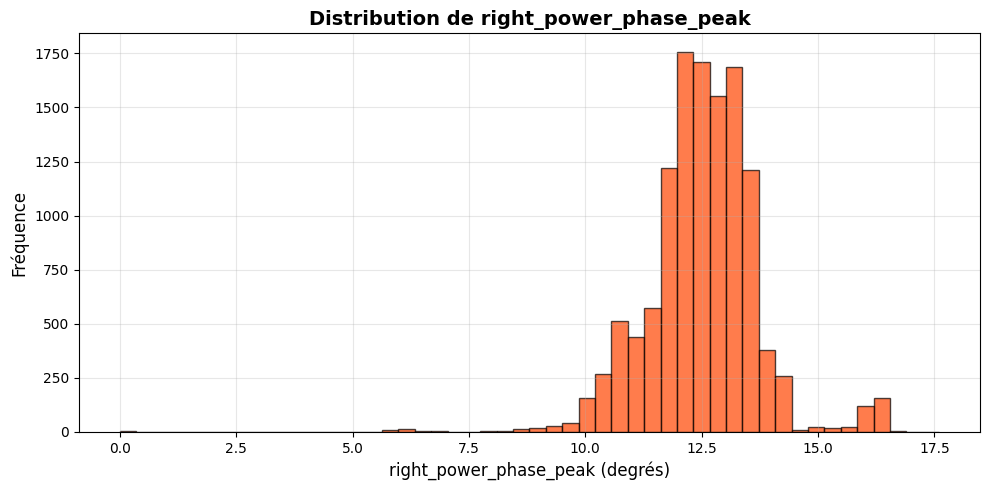

🔄 Décomposition STL en cours...


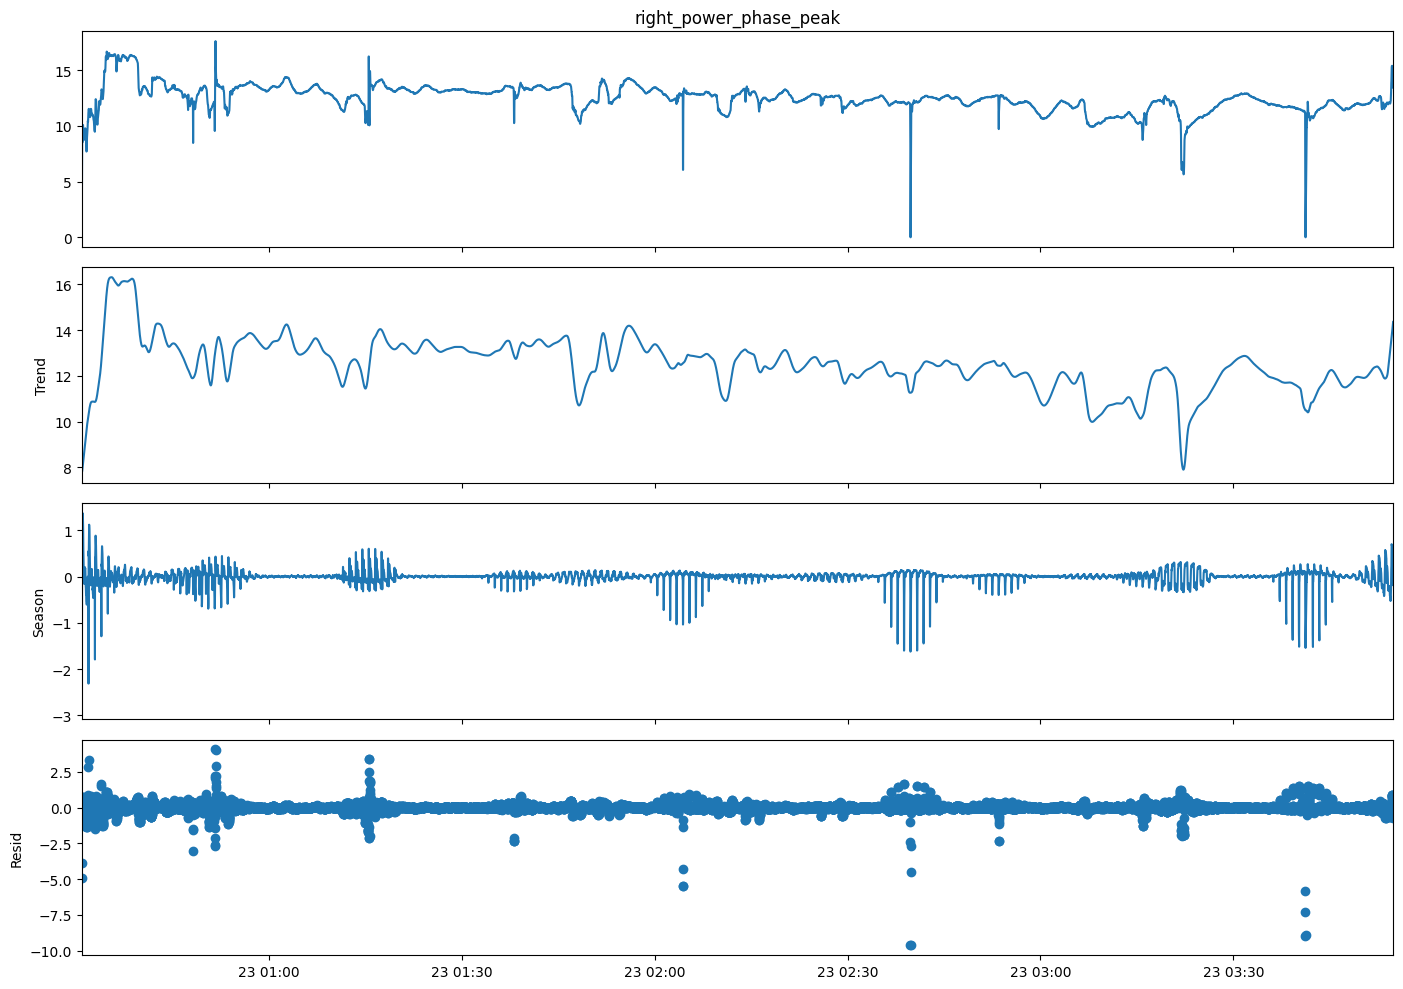

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -5.715666
P-value: 0.000001

Valeurs critiques:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)


In [49]:
# ======================================
# 📂 2. Chargement du dataset
# ======================================
filepath = r'C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv'

# Charger le CSV (délimiteur virgule standard)
df = pd.read_csv(filepath)

print(f"✅ Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")
print(f"\nColonnes disponibles: {df.columns.tolist()}")

# Vérifier si right_power_phase_peak a des données
if 'right_power_phase_peak' in df.columns:
    non_null = df['right_power_phase_peak'].notna().sum()
    print(f"\n✅ Colonne 'right_power_phase_peak': {non_null} valeurs non-nulles ({non_null/len(df)*100:.1f}%)")
    print(f"   Premières valeurs: {df['right_power_phase_peak'].head().tolist()}")

# Afficher les premières lignes
df.head()

# ======================================
# 🔍 3. Vérification de right_power_phase_peak
# ======================================
target_col = 'right_power_phase_peak'

if target_col not in df.columns:
    raise ValueError(f"La colonne '{target_col}' n'existe pas! Colonnes: {df.columns.tolist()}")

print(f"✅ Colonne '{target_col}' trouvée")
print(f"\nStatistiques avant nettoyage:")
print(f"  - Total de lignes: {len(df)}")
print(f"  - Valeurs non-nulles: {df[target_col].notna().sum()}")
print(f"  - Valeurs nulles: {df[target_col].isna().sum()}")

# Afficher les premières valeurs
print(f"\nPremières valeurs de {target_col}:")
print(df[target_col].head(10))

# ======================================
# 🧹 4. Nettoyage des données
# ======================================

print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(df)} lignes")

# Convertir en numérique
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
print(f"  Après conversion numérique: {df[target_col].notna().sum()} valeurs non-nulles")

# Vérifier la présence de GOTOES_CSV
if 'GOTOES_CSV' in df.columns:
    print(f"  Colonne 'GOTOES_CSV' présente: {df['GOTOES_CSV'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur GOTOES_CSV: {df['GOTOES_CSV'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'GOTOES_CSV' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(df)}")
print(f"  - Lignes après: {len(df)}")
print(f"  - Lignes supprimées: {len(df) - len(df)}")

# Créer une série temporelle avec index
if 'GOTOES_CSV' in df.columns:
    print(f"\n🔍 Création de l'index temporel avec 'GOTOES_CSV'...")
    
    # Sélectionner les colonnes
    ts_data = df[['GOTOES_CSV', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    
    # Dropna sur les deux colonnes
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    
    # Convertir en datetime
    ts_data['GOTOES_CSV'] = pd.to_datetime(ts_data['GOTOES_CSV'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['GOTOES_CSV'].notna().sum()} timestamps valides")
    
    # Dropna final
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    # Mettre en index
    ts_data = ts_data.set_index('GOTOES_CSV')
    print(f"\n✅ Index temporel basé sur 'GOTOES_CSV'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in df.columns:
    ts_data = df[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = df[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

# ======================================
# 📊 5. Visualisation de la série temporelle
# ======================================

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

# ======================================
# 📊 6. Statistiques de base
# ======================================

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")

# Histogramme
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================
# 🔄 7. Décomposition STL (Seasonal-Trend-Loess)
# ======================================

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    # Choisir une période appropriée (par exemple 60 pour une minute si données par seconde)
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    # Visualiser la décomposition
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

# ======================================
# 📈 8. Test de stationnarité (Augmented Dickey-Fuller)
# ======================================

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

# Interprétation
if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

# Marathon 2

✅ Dataset chargé: 12788 lignes, 123 colonnes

Colonnes disponibles: ['GOTOES_CSV', 'timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance', 'grade', 'resistance', 'time_from_course', 'cycle_length', 'temperature', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'speed_1s', 'cycles', 'total_cycles', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'compressed_accumulated_power', 'accumulated_power', 'left_right_balance', 'gps_accuracy', 'vertical_speed', 'calories', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'vertical_oscillation', 'stance_time_percent', 'stance_time', 'activity_type', 'left_torque_effectiveness', 'right_torque_effectiveness', 'left_pedal_smoothness', 'right_pedal_smoothness', 'combined_pedal_smoothness', 'time128', 'stroke_type', 'zone', 'ball_speed', 'cadence256', 'fractional_cadence', 

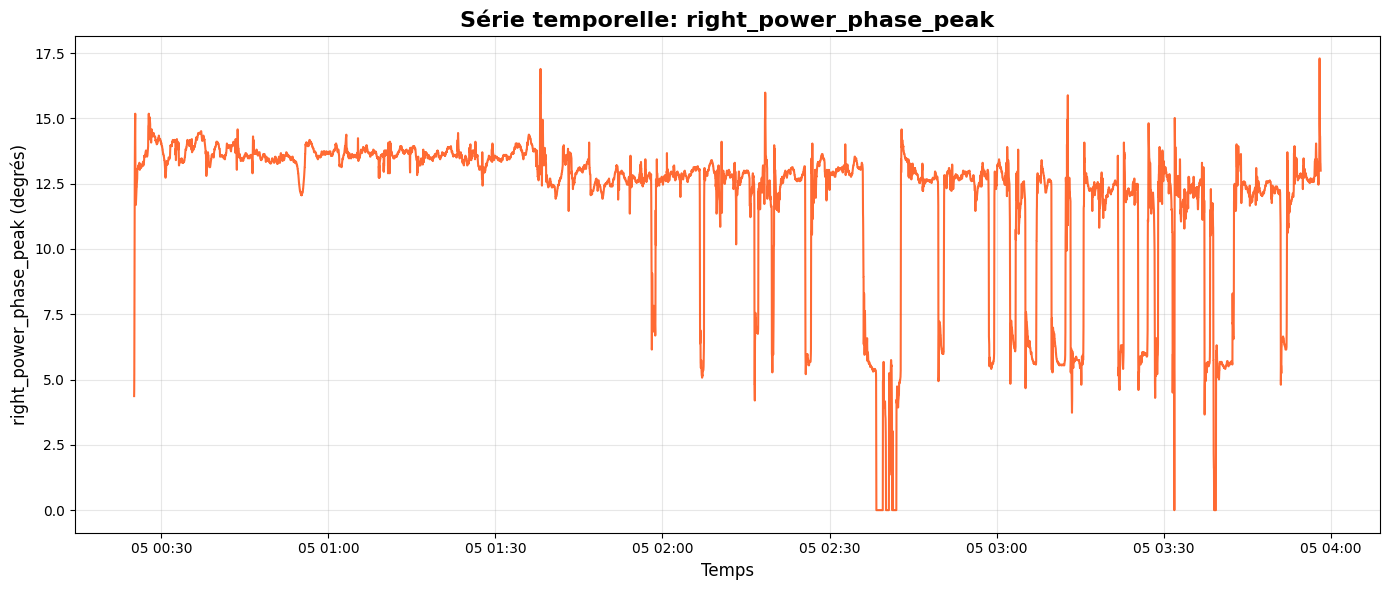

📈 Graphique de la série temporelle affiché
STATISTIQUES DESCRIPTIVES
Moyenne        : 11.9487°
Médiane        : 12.8660°
Écart-type     : 2.8603°
Min            : 0.0000°
Max            : 17.2980°
Q1 (25%)       : 12.2620°
Q3 (75%)       : 13.5040°


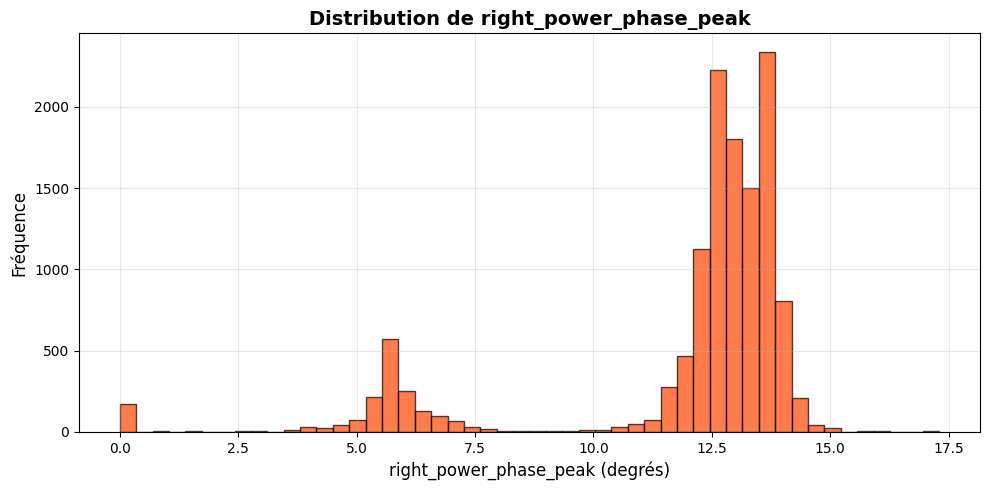

🔄 Décomposition STL en cours...


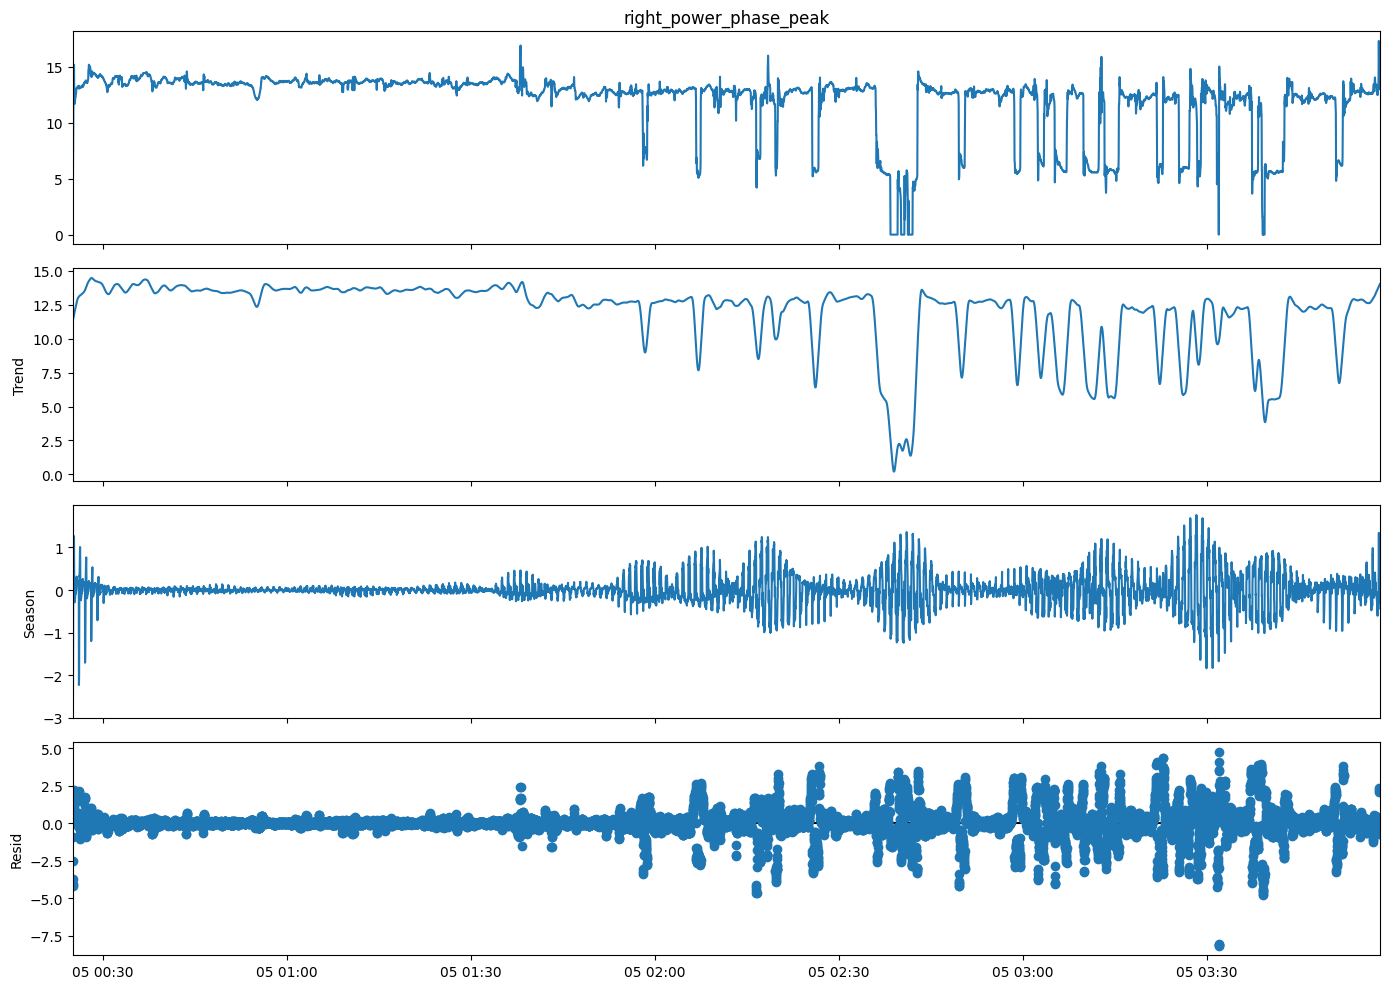

✅ Décomposition STL effectuée (période=60)
TEST DE STATIONNARITÉ (ADF)

Statistique ADF: -7.316234
P-value: 0.000000

Valeurs critiques:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✅ La série est STATIONNAIRE (p-value < 0.05)


In [50]:
# ======================================
# 📂 2. Chargement du dataset
# ======================================
filepath = r'C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_2.csv'

# Charger le CSV (délimiteur virgule standard)
df = pd.read_csv(filepath)

print(f"✅ Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")
print(f"\nColonnes disponibles: {df.columns.tolist()}")

# Vérifier si right_power_phase_peak a des données
if 'right_power_phase_peak' in df.columns:
    non_null = df['right_power_phase_peak'].notna().sum()
    print(f"\n✅ Colonne 'right_power_phase_peak': {non_null} valeurs non-nulles ({non_null/len(df)*100:.1f}%)")
    print(f"   Premières valeurs: {df['right_power_phase_peak'].head().tolist()}")

# Afficher les premières lignes
df.head()

# ======================================
# 🔍 3. Vérification de right_power_phase_peak
# ======================================
target_col = 'right_power_phase_peak'

if target_col not in df.columns:
    raise ValueError(f"La colonne '{target_col}' n'existe pas! Colonnes: {df.columns.tolist()}")

print(f"✅ Colonne '{target_col}' trouvée")
print(f"\nStatistiques avant nettoyage:")
print(f"  - Total de lignes: {len(df)}")
print(f"  - Valeurs non-nulles: {df[target_col].notna().sum()}")
print(f"  - Valeurs nulles: {df[target_col].isna().sum()}")

# Afficher les premières valeurs
print(f"\nPremières valeurs de {target_col}:")
print(df[target_col].head(10))

# ======================================
# 🧹 4. Nettoyage des données
# ======================================

print("🔍 DIAGNOSTIC DU NETTOYAGE:")
print(f"  Données de départ: {len(df)} lignes")

# Convertir en numérique
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
print(f"  Après conversion numérique: {df[target_col].notna().sum()} valeurs non-nulles")

# Vérifier la présence de GOTOES_CSV
if 'GOTOES_CSV' in df.columns:
    print(f"  Colonne 'GOTOES_CSV' présente: {df['GOTOES_CSV'].notna().sum()} valeurs non-nulles")
    print(f"  Exemple de valeur GOTOES_CSV: {df['GOTOES_CSV'].iloc[0]}")
else:
    print(f"  ❌ Colonne 'GOTOES_CSV' ABSENTE!")

print(f"\n✅ Nettoyage effectué:")
print(f"  - Lignes avant: {len(df)}")
print(f"  - Lignes après: {len(df)}")
print(f"  - Lignes supprimées: {len(df) - len(df)}")

# Créer une série temporelle avec index
if 'GOTOES_CSV' in df.columns:
    print(f"\n🔍 Création de l'index temporel avec 'GOTOES_CSV'...")
    
    # Sélectionner les colonnes
    ts_data = df[['GOTOES_CSV', target_col]].copy()
    print(f"  Après sélection colonnes: {len(ts_data)} lignes")
    
    # Dropna sur les deux colonnes
    ts_data = ts_data.dropna()
    print(f"  Après dropna initial: {len(ts_data)} lignes")
    
    # Convertir en datetime
    ts_data['GOTOES_CSV'] = pd.to_datetime(ts_data['GOTOES_CSV'], errors='coerce')
    print(f"  Après conversion datetime: {ts_data['GOTOES_CSV'].notna().sum()} timestamps valides")
    
    # Dropna final
    ts_data = ts_data.dropna()
    print(f"  Après dropna final: {len(ts_data)} lignes")
    
    # Mettre en index
    ts_data = ts_data.set_index('GOTOES_CSV')
    print(f"\n✅ Index temporel basé sur 'GOTOES_CSV'")
    if len(ts_data) > 0:
        print(f"\n⏱️ Plage temporelle de la série :")
        print(f"  Début : {ts_data.index.min()}")
        print(f"  Fin   : {ts_data.index.max()}")
        print(f"  Durée totale : {ts_data.index.max() - ts_data.index.min()}")

    
elif 'timestamp' in df.columns:
    ts_data = df[['timestamp', target_col]].dropna().copy()
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], errors='coerce')
    ts_data = ts_data.dropna().set_index('timestamp')
    print(f"\n✅ Index temporel basé sur 'timestamp'")
else:
    ts_data = df[[target_col]].dropna().copy()
    ts_data.index = range(len(ts_data))
    print(f"\n✅ Index temporel numérique créé")

print(f"\n{'='*60}")
print(f"RÉSULTAT FINAL: {len(ts_data)} points valides")
print(f"{'='*60}")

if len(ts_data) > 0:
    print(f"\nPremières valeurs de la série:")
    print(ts_data.head())
    print(f"\nStatistiques descriptives:")
    print(ts_data[target_col].describe())
else:
    print("⚠️ ATTENTION: Aucune donnée valide après nettoyage!")
    print("Vérifiez les étapes de diagnostic ci-dessus.")

# ======================================
# 📊 5. Visualisation de la série temporelle
# ======================================

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data[target_col], color='orangered', linewidth=1.5, alpha=0.8)
plt.title(f'Série temporelle: {target_col}', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel(f'{target_col} (degrés)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Graphique de la série temporelle affiché")

# ======================================
# 📊 6. Statistiques de base
# ======================================

print("=" * 60)
print("STATISTIQUES DESCRIPTIVES")
print("=" * 60)

stats = {
    'Moyenne': ts_data[target_col].mean(),
    'Médiane': ts_data[target_col].median(),
    'Écart-type': ts_data[target_col].std(),
    'Min': ts_data[target_col].min(),
    'Max': ts_data[target_col].max(),
    'Q1 (25%)': ts_data[target_col].quantile(0.25),
    'Q3 (75%)': ts_data[target_col].quantile(0.75)
}

for key, value in stats.items():
    print(f"{key:15s}: {value:.4f}°")

# Histogramme
plt.figure(figsize=(10, 5))
plt.hist(ts_data[target_col], bins=50, color='orangered', edgecolor='black', alpha=0.7)
plt.title(f'Distribution de {target_col}', fontsize=14, fontweight='bold')
plt.xlabel(f'{target_col} (degrés)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================
# 🔄 7. Décomposition STL (Seasonal-Trend-Loess)
# ======================================

if len(ts_data) >= 100:
    print("🔄 Décomposition STL en cours...")
    
    # Choisir une période appropriée (par exemple 60 pour une minute si données par seconde)
    period = min(60, len(ts_data) // 3)
    
    stl = STL(ts_data[target_col], period=period, seasonal=13)
    result = stl.fit()
    
    # Visualiser la décomposition
    fig = result.plot()
    fig.set_size_inches(14, 10)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Décomposition STL effectuée (période={period})")
else:
    print(f"⚠️ Série trop courte ({len(ts_data)} points) pour une décomposition STL fiable.")

# ======================================
# 📈 8. Test de stationnarité (Augmented Dickey-Fuller)
# ======================================

print("=" * 60)
print("TEST DE STATIONNARITÉ (ADF)")
print("=" * 60)

result_adf = adfuller(ts_data[target_col].dropna())

print(f"\nStatistique ADF: {result_adf[0]:.6f}")
print(f"P-value: {result_adf[1]:.6f}")
print(f"\nValeurs critiques:")
for key, value in result_adf[4].items():
    print(f"  {key}: {value:.3f}")

# Interprétation
if result_adf[1] < 0.05:
    print(f"\n✅ La série est STATIONNAIRE (p-value < 0.05)")
else:
    print(f"\n⚠️ La série est NON-STATIONNAIRE (p-value >= 0.05)")
    print("   → Considérer une différenciation ou une transformation")

# Comparaison 6 courses

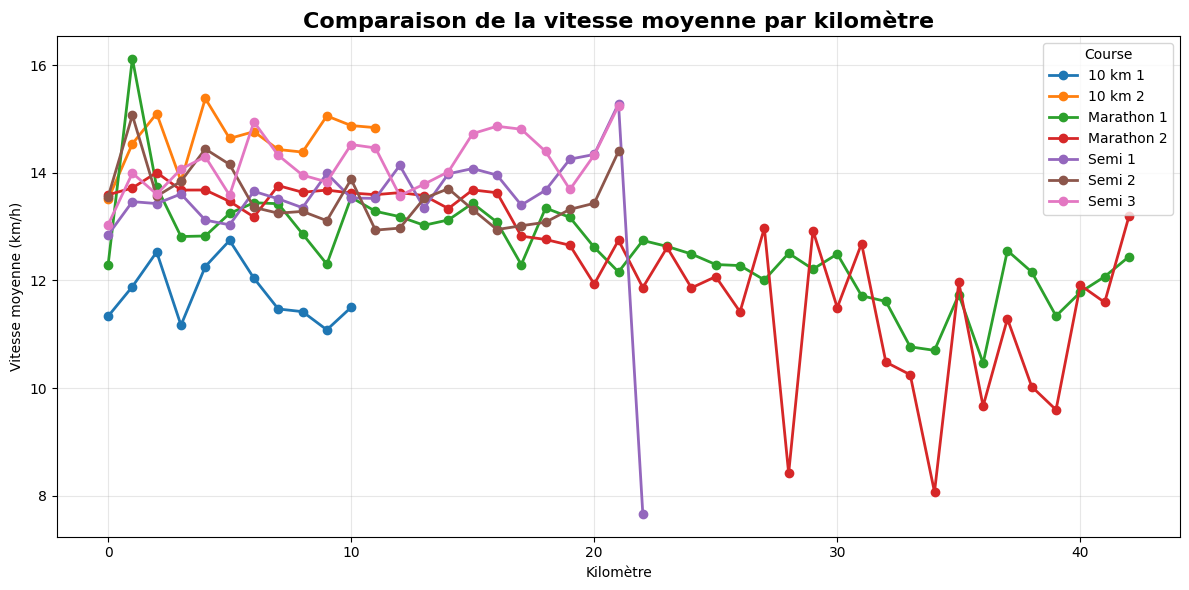

📊 Statistiques de vitesse moyenne (km/h) par course :
             mean   std    min    max
course                               
10 km 1     11.77  0.56  11.08  12.74
10 km 2     14.62  0.53  13.51  15.38
Marathon 1  12.57  0.95  10.46  16.12
Marathon 2  12.34  1.51   8.07  14.01
Semi 1      13.44  1.36   7.66  15.29
Semi 2      13.55  0.56  12.94  15.07
Semi 3      14.19  0.54  13.03  15.25


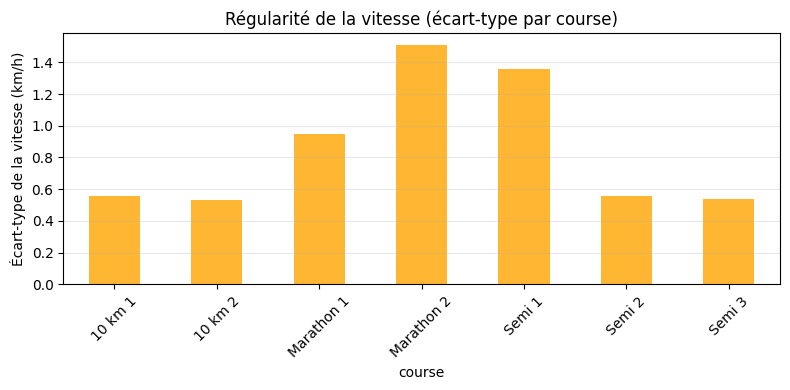

In [30]:
# ======================================
# 📦 1. Imports et chargement des fichiers
# ======================================
import pandas as pd
import matplotlib.pyplot as plt

# ⚠️ Remplace les chemins par les tiens
semi1 = pd.read_csv(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_1.csv")
semi2 = pd.read_csv(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_2.csv")
semi3 = pd.read_csv(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_3.csv")
marathon1 = pd.read_csv(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv")
marathon2 = pd.read_csv(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_2.csv")
dix1 = pd.read_csv(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_1.csv")
dix2 = pd.read_csv(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_2.csv")

# ======================================
# 🧩 2. Fonction : vitesse moyenne (right_power_phase_peak) par km
# ======================================
def get_speed_per_km(df, name):
    """
    Calcule la vitesse moyenne (km/h) pour chaque kilomètre parcouru,
    en utilisant 'cadence' comme proxy de la distance (en mètres)
    et 'right_power_phase_peak' comme vitesse (déjà en km/h).
    """
    # Vérifie les colonnes
    if 'cadence' not in df.columns or 'right_power_phase_peak' not in df.columns:
        raise ValueError(f"❌ Colonnes manquantes dans {name}. Il faut 'cadence' et 'right_power_phase_peak'")
    
    # Copie de sécurité
    df = df.copy()
    
    # Conversion cadence → distance cumulée en km
    df['distance_km'] = df['cadence'] / 1000

    # Nettoyage : suppression des valeurs aberrantes
    df = df.dropna(subset=['distance_km', 'right_power_phase_peak'])
    df = df[(df['right_power_phase_peak'] > 0) & (df['right_power_phase_peak'] < 25)]  # filtre valeurs absurdes

    # Calcul du km courant (tronqué à l’entier inférieur)
    df['km_bin'] = df['distance_km'].astype(int)

    # Moyenne par km (déjà en km/h)
    mean_speed = df.groupby('km_bin')['right_power_phase_peak'].mean()

    # Construction du DataFrame final
    return pd.DataFrame({
        'km': mean_speed.index,
        'speed_kmh': mean_speed.values,
        'course': name
    })

# ======================================
# ⚙️ 3. Application aux 7 fichiers
# ======================================
dfs = [
    get_speed_per_km(semi1, "Semi 1"),
    get_speed_per_km(semi2, "Semi 2"),
    get_speed_per_km(semi3, "Semi 3"),
    get_speed_per_km(marathon1, "Marathon 1"),
    get_speed_per_km(marathon2, "Marathon 2"),
    get_speed_per_km(dix1, "10 km 1"),
    get_speed_per_km(dix2, "10 km 2")
]

# Fusion en un seul DataFrame
speed_profiles = pd.concat(dfs, ignore_index=True)

# ======================================
# 📈 4. Visualisation comparative
# ======================================
plt.figure(figsize=(12, 6))

for name, grp in speed_profiles.groupby('course'):
    plt.plot(grp['km'], grp['speed_kmh'], marker='o', linewidth=2, label=name)

plt.title("Comparaison de la vitesse moyenne par kilomètre", fontsize=16, fontweight='bold')
plt.xlabel("Kilomètre")
plt.ylabel("Vitesse moyenne (km/h)")
plt.grid(True, alpha=0.3)
plt.legend(title="Course", fontsize=10)
plt.tight_layout()
plt.show()

# ======================================
# 📊 5. Statistiques globales par course
# ======================================
summary = speed_profiles.groupby('course')['speed_kmh'].agg(['mean', 'std', 'min', 'max']).round(2)

print("📊 Statistiques de vitesse moyenne (km/h) par course :")
print(summary)

# ======================================
# 📉 6. Visualisation de la régularité (écart-type)
# ======================================
plt.figure(figsize=(8, 4))
summary['std'].plot(kind='bar', color='orange', alpha=0.8)
plt.title("Régularité de la vitesse (écart-type par course)")
plt.ylabel("Écart-type de la vitesse (km/h)")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [42]:
# ======================================
# 📦 1. Imports complémentaires
# ======================================
import seaborn as sns
import numpy as np

# ======================================
# 📂 2. Fonction pour analyser les corrélations d’une course
# ======================================
def analyse_correlation(df, course_name):
    """
    Calcule et affiche les corrélations entre :
      - vitesse (right_power_phase_peak)
      - fréquence cardiaque (heart_rate)
      - altitude (elevation_gain ou altitude)
    """
    # Vérifier que les colonnes nécessaires existent
    cols_needed = ['right_power_phase_peak', 'heart_rate', 'altitude']
    for col in cols_needed:
        if col not in df.columns:
            raise ValueError(f"❌ Colonne '{col}' absente dans {course_name}")

    # Nettoyage basique
    df = df.copy()
    df = df.dropna(subset=cols_needed)
    df = df[(df['right_power_phase_peak'] > 0) & (df['heart_rate'] > 40) & (df['altitude'] > 0)]

    # Corrélations simples
    corr_speed_hr = df['right_power_phase_peak'].corr(df['heart_rate'])
    corr_speed_alt = df['right_power_phase_peak'].corr(df['altitude'])

    print(f"📊 Corrélations pour {course_name}:")
    print(f"  ➕ Corr(vitesse, fréquence cardiaque) = {corr_speed_hr:.3f}")
    print(f"  ➖ Corr(vitesse, altitude) = {corr_speed_alt:.3f}\n")

    # ======================================
    # 📈 3. Visualisation : scatterplots
    # ======================================
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Vitesse vs Fréquence cardiaque
    sns.regplot(
        x='heart_rate', y='right_power_phase_peak', data=df,
        ax=axes[0], scatter_kws={'alpha':0.4}, line_kws={'color':'red'}
    )
    axes[0].set_title(f"{course_name} — Corr(vitesse, fréquence cardiaque) = {corr_speed_hr:.2f}")
    axes[0].set_xlabel("Fréquence cardiaque (bpm)")
    axes[0].set_ylabel("Vitesse (km/h)")
    axes[0].grid(alpha=0.3)

    # Vitesse vs Altitude
    sns.regplot(
        x='altitude', y='right_power_phase_peak', data=df,
        ax=axes[1], scatter_kws={'alpha':0.4}, line_kws={'color':'red'}
    )
    axes[1].set_title(f"{course_name} — Corr(vitesse, altitude) = {corr_speed_alt:.2f}")
    axes[1].set_xlabel("Altitude (m)")
    axes[1].set_ylabel("Vitesse (km/h)")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ======================================
    # 🔍 4. Analyse complémentaire (facultative)
    # ======================================
    # Détection d’un éventuel seuil de saturation cardiaque
    # (quand le cœur monte mais la vitesse ne suit plus)
    df_sorted = df.sort_values('heart_rate')
    df_sorted['rolling_speed'] = df_sorted['right_power_phase_peak'].rolling(window=30).mean()

    plt.figure(figsize=(10,4))
    plt.plot(df_sorted['heart_rate'], df_sorted['rolling_speed'], color='dodgerblue')
    plt.title(f"{course_name} — Relation vitesse vs fréquence cardiaque (moyenne glissante)")
    plt.xlabel("Fréquence cardiaque (bpm)")
    plt.ylabel("Vitesse (km/h)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return corr_speed_hr, corr_speed_alt


📊 Corrélations pour Marathon 1:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.367
  ➖ Corr(vitesse, altitude) = 0.154



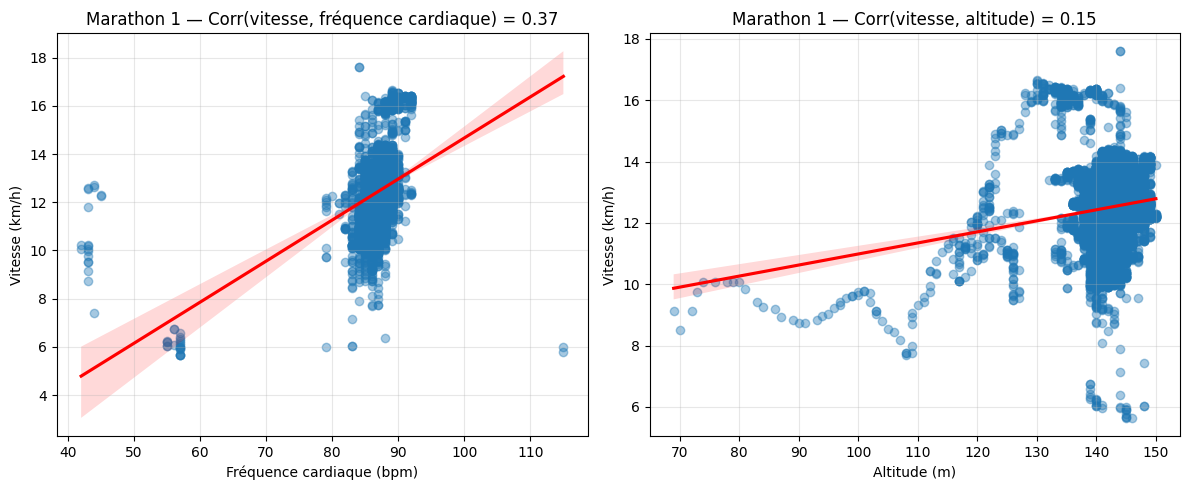

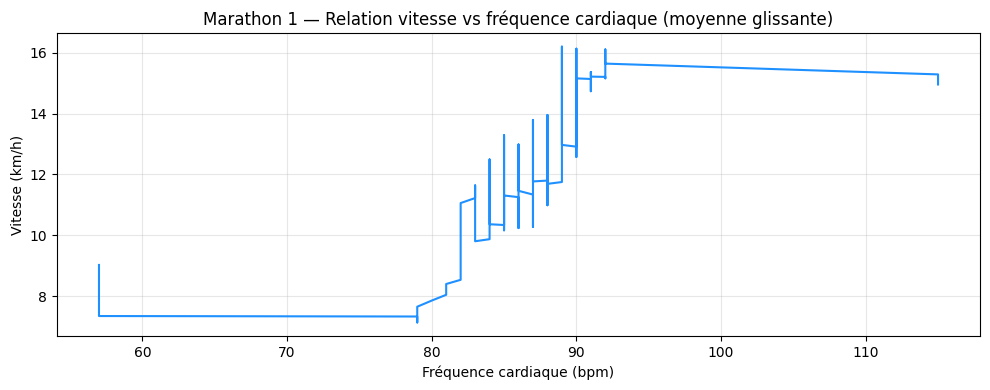

📊 Corrélations pour Marathon 2:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.909
  ➖ Corr(vitesse, altitude) = -0.174



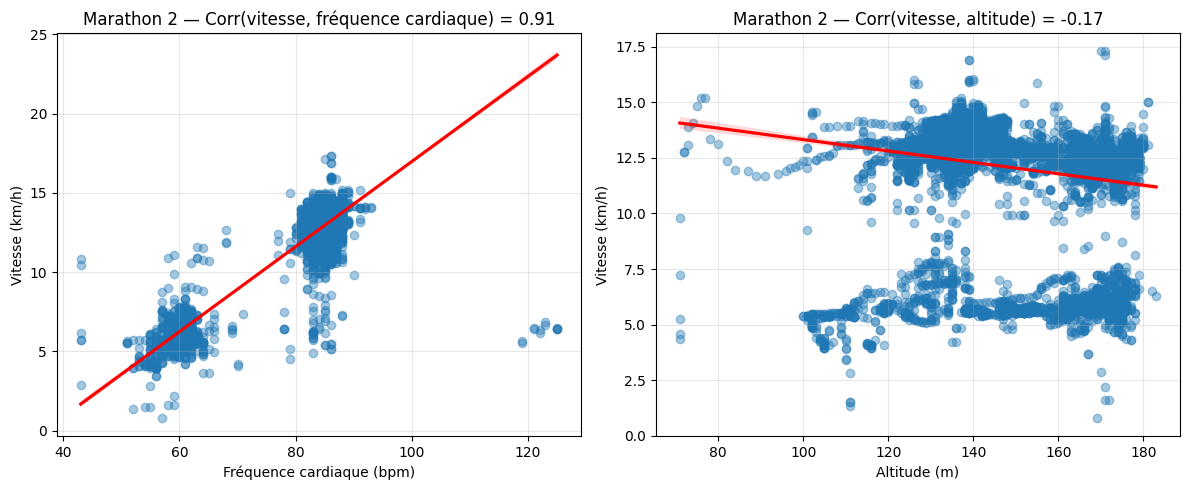

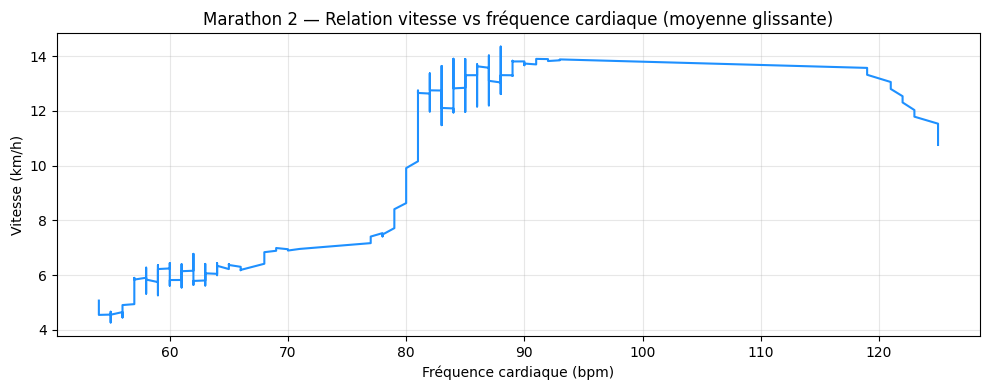

📊 Corrélations pour 10 km 1:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.415
  ➖ Corr(vitesse, altitude) = 0.169



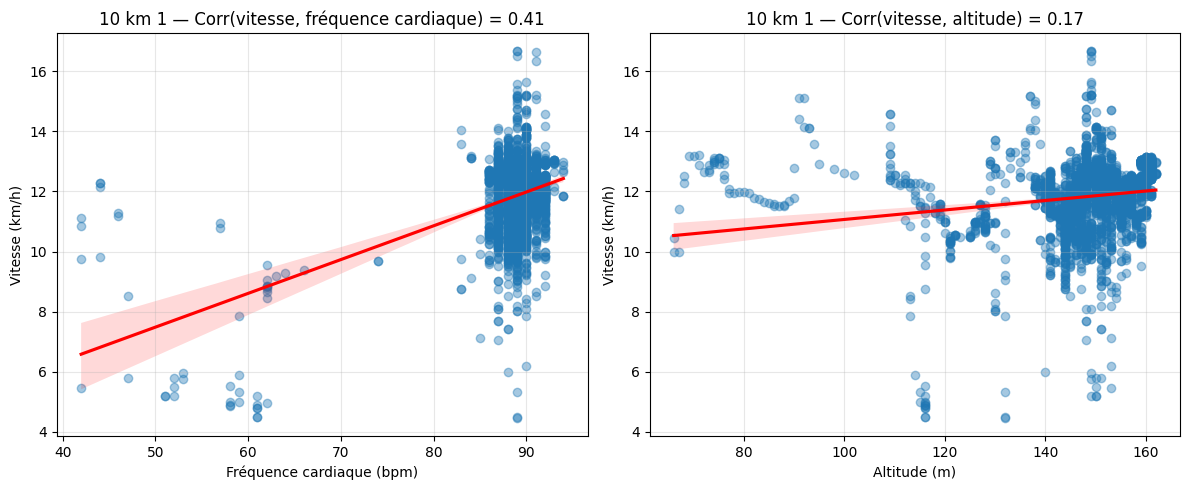

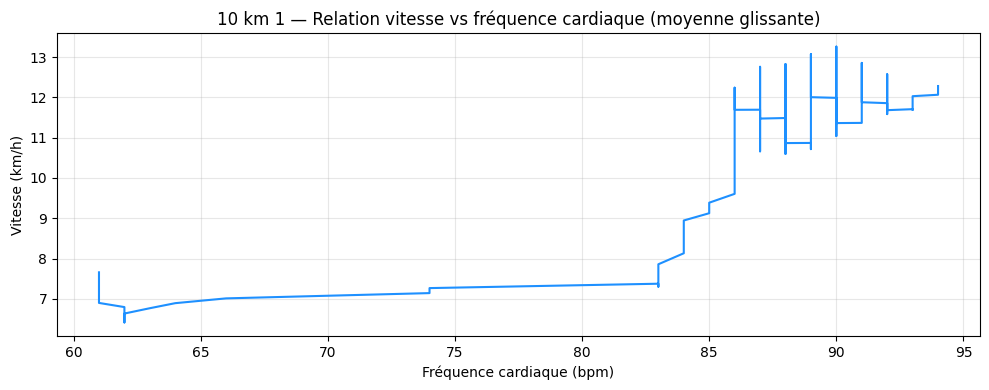

📊 Corrélations pour 10 km 2:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.236
  ➖ Corr(vitesse, altitude) = 0.286



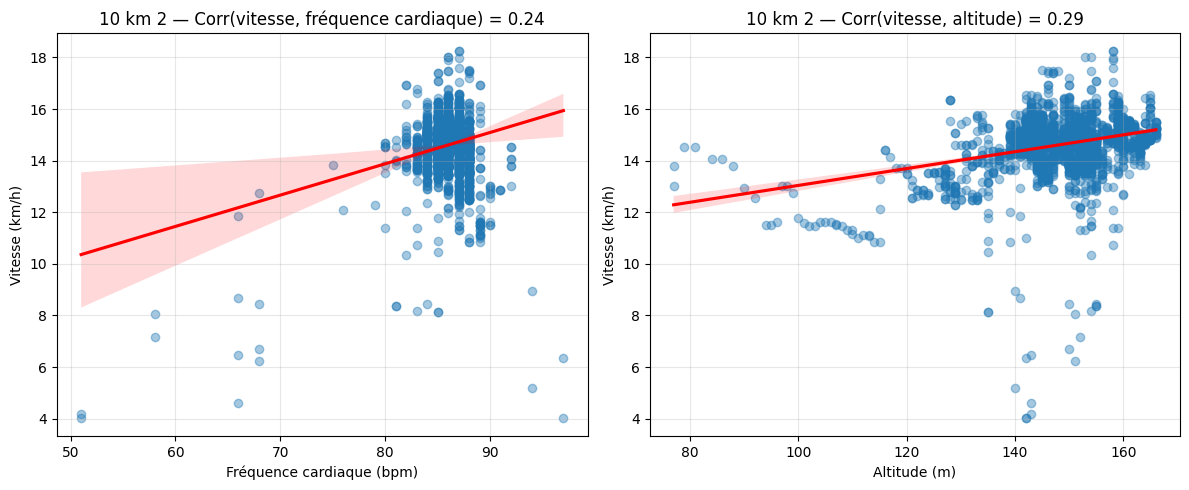

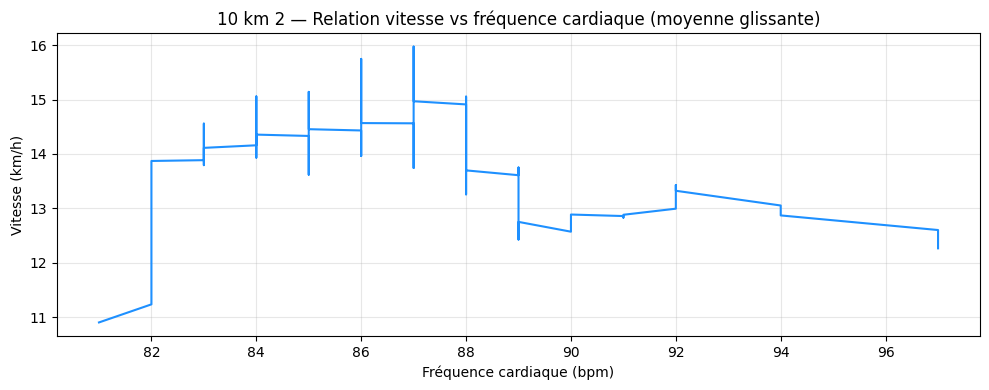

📊 Corrélations pour Semi 1:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.532
  ➖ Corr(vitesse, altitude) = -0.045



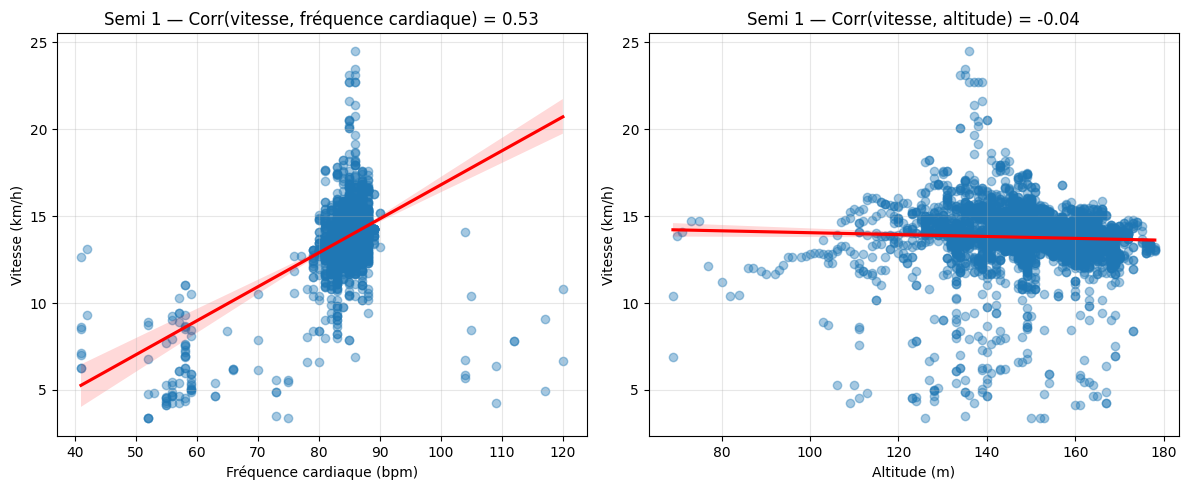

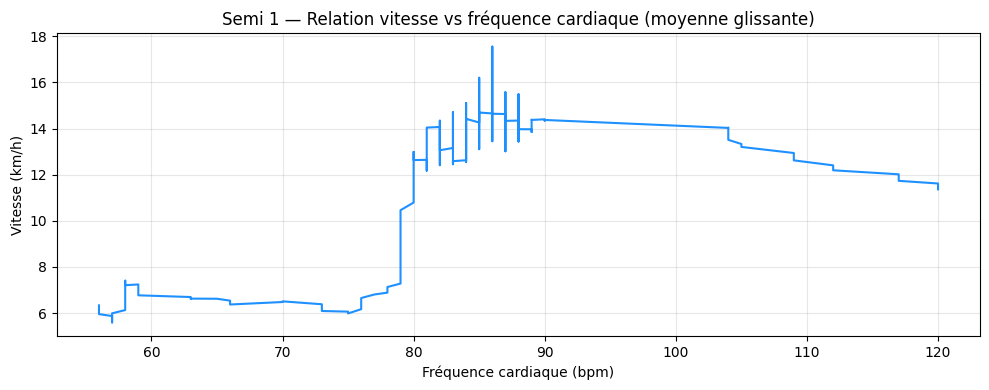

📊 Corrélations pour Semi 2:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.331
  ➖ Corr(vitesse, altitude) = 0.100



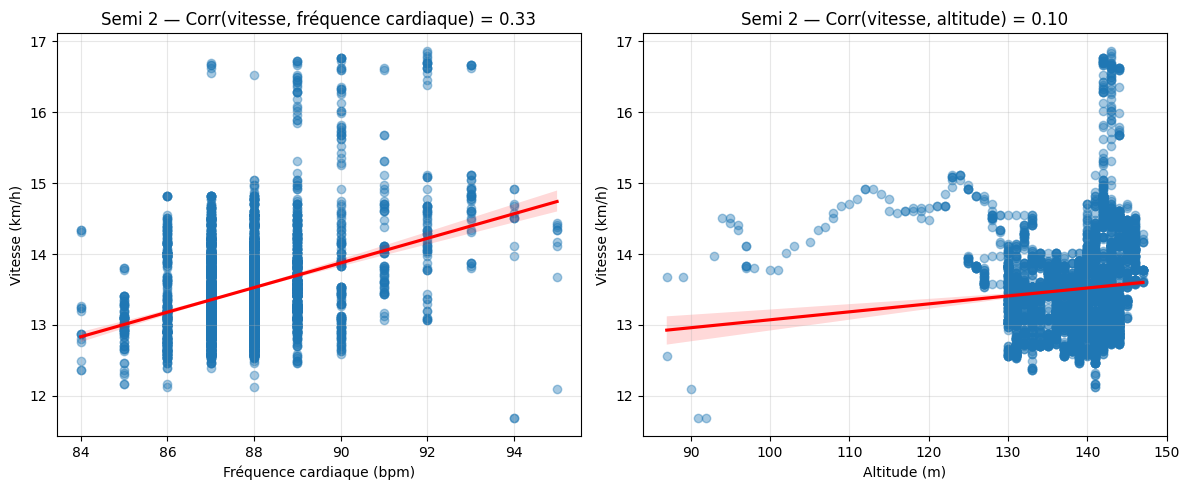

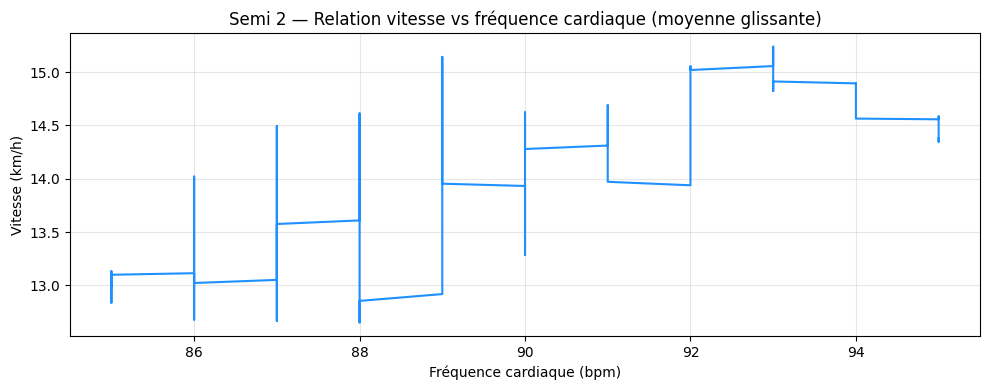

📊 Corrélations pour Semi 3:
  ➕ Corr(vitesse, fréquence cardiaque) = 0.641
  ➖ Corr(vitesse, altitude) = 0.186



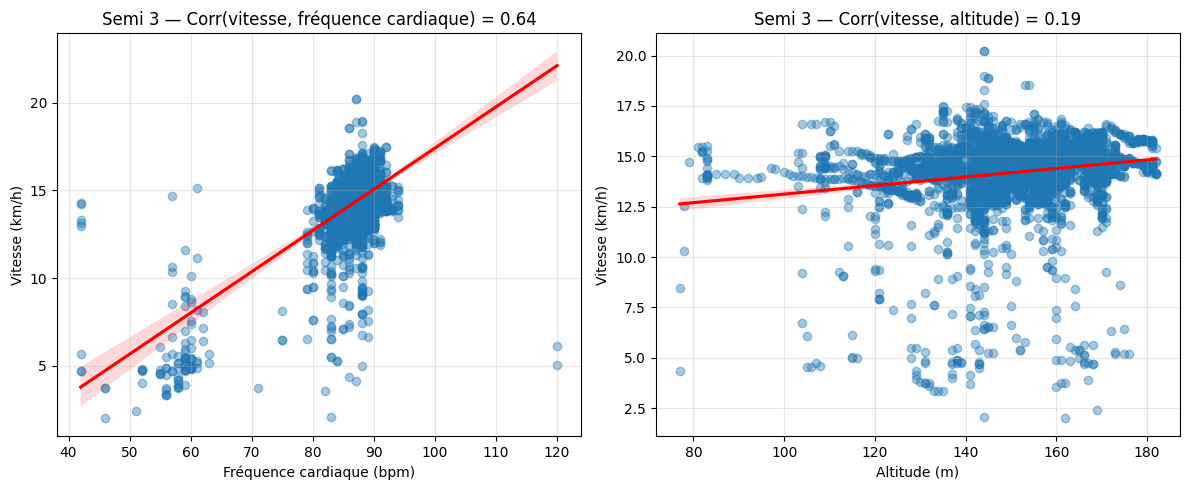

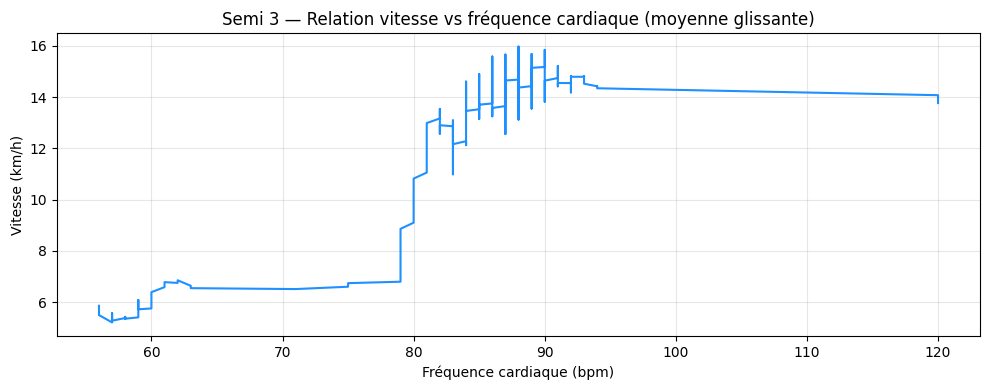

In [43]:
# Exemple sur les deux marathons
corr_m1 = analyse_correlation(marathon1, "Marathon 1")
corr_m2 = analyse_correlation(marathon2, "Marathon 2")

# Exemple sur les 10 km
corr_10k1 = analyse_correlation(dix1, "10 km 1")
corr_10k2 = analyse_correlation(dix2, "10 km 2")

# Exemple sur les semis
corr_s1 = analyse_correlation(semi1, "Semi 1")
corr_s2 = analyse_correlation(semi2, "Semi 2")
corr_s3 = analyse_correlation(semi3, "Semi 3")


In [59]:
# ======================================
# 📦 1. Imports
# ======================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ======================================
# ⚙️ 2. Paramètres de simulation
# ======================================
FCM = 115  # fréquence cardiaque max estimée (220 - 21)
SEUIL_FATIGUE = 0.9 * FCM       # 90% FCM
DUREE_SEUIL = 3 * 60            # 5 minutes = 300 secondes

# ======================================
# 🧠 3. Fonction de détection de fatigue
# ======================================
def detect_fatigue(df, course_name):
    """
    Détecte les périodes où le rythme cardiaque dépasse 90% FCM
    pendant plus de 5 minutes consécutives.
    Indique ensuite la baisse de vitesse moyenne.
    """
    # Vérifications
    cols_needed = ['timestamp', 'heart_rate', 'right_power_phase_peak']
    for c in cols_needed:
        if c not in df.columns:
            raise ValueError(f"❌ Colonne manquante : {c} dans {course_name}")

    # Copie et nettoyage
    data = df[['timestamp', 'heart_rate', 'right_power_phase_peak']].dropna().copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data = data.sort_values('timestamp')
    
    # Détection des segments où HR > 90% FCM
    data['is_fatigue_zone'] = data['heart_rate'] > SEUIL_FATIGUE

    # Regrouper les zones consécutives
    data['fatigue_group'] = (data['is_fatigue_zone'] != data['is_fatigue_zone'].shift()).cumsum()

    fatigue_segments = []
    for grp, subset in data.groupby('fatigue_group'):
        if subset['is_fatigue_zone'].iloc[0]:
            duration = (subset['timestamp'].iloc[-1] - subset['timestamp'].iloc[0]).total_seconds()
            if duration >= DUREE_SEUIL:
                avg_speed = subset['right_power_phase_peak'].mean()
                fatigue_segments.append({
                    'start': subset['timestamp'].iloc[0],
                    'end': subset['timestamp'].iloc[-1],
                    'duration_sec': duration,
                    'avg_speed': avg_speed
                })

    # ======================================
    # 📈 4. Visualisation de la fatigue
    # ======================================
    plt.figure(figsize=(12, 6))
    plt.plot(data['timestamp'], data['right_power_phase_peak'], label='Vitesse (km/h)', color='steelblue')
    plt.plot(data['timestamp'], data['heart_rate'] / 10, label='Fréquence cardiaque (bpm /10)', color='red', alpha=0.6)
    
    # Marquage des segments de fatigue
    for seg in fatigue_segments:
        plt.axvspan(seg['start'], seg['end'], color='orange', alpha=0.3, label='Fatigue détectée')
    
    plt.title(f"🩸 Simulation de la fatigue — {course_name}")
    plt.xlabel("Temps")
    plt.ylabel("Valeurs (km/h et bpm/10)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ======================================
    # 🧾 5. Résumé
    # ======================================
    print(f"Résultats pour {course_name} :")
    if fatigue_segments:
        for i, seg in enumerate(fatigue_segments, 1):
            print(f"⚠️ Segment {i}:")
            print(f"   - Début      : {seg['start']}")
            print(f"   - Fin        : {seg['end']}")
            print(f"   - Durée      : {seg['duration_sec']/60:.1f} minutes")
            print(f"   - Vitesse moy: {seg['avg_speed']:.2f} km/h\n")
    else:
        print("✅ Aucune période de fatigue prolongée détectée (cardio < 90% FCM).")

    return fatigue_segments


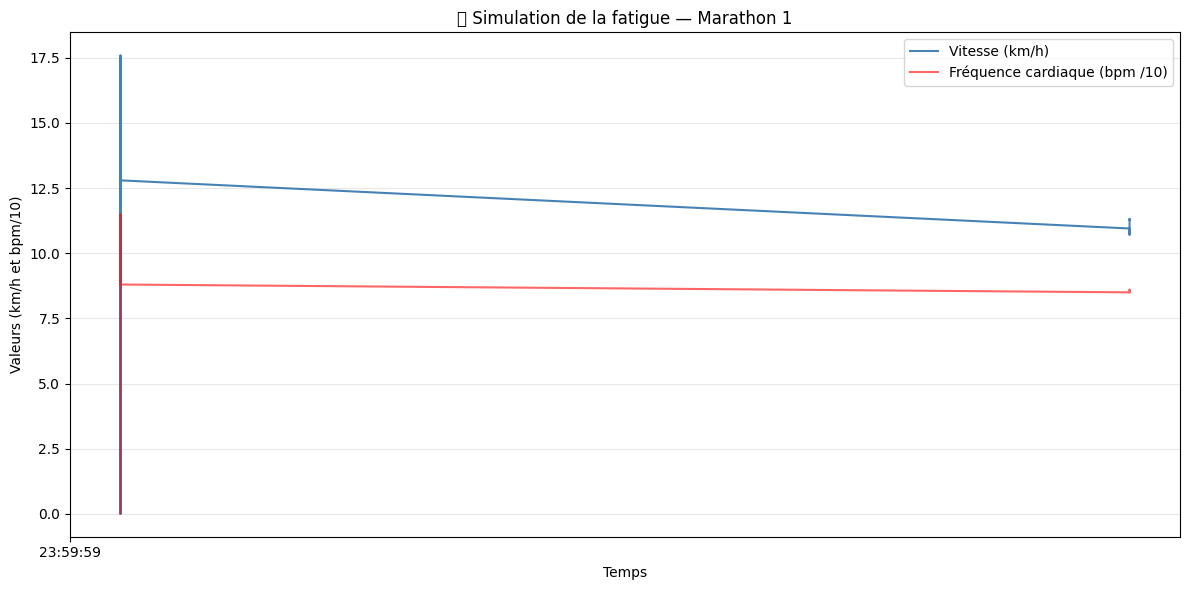

Résultats pour Marathon 1 :
✅ Aucune période de fatigue prolongée détectée (cardio < 90% FCM).


In [62]:
fatigue_marathon1 = detect_fatigue(marathon1, "Marathon 1")

In [39]:
check = pd.read_csv(r'C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv')


In [58]:
check['heart_rate'].max()

np.int64(115)